In [4]:
import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ============================================================
# 0) Reproducibility
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Config (Trial9: + PH / α–λ / RA / convergence)
# ============================================================
@dataclass
class Config:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
    out_dir: str = r"./Trial9"

    # seeds to sweep
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # sliding window
    seq_len: int = 100
    stride: int = 5
    pred_horizon: int = 0

    # split by FILE
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1

    # training
    batch_size: int = 512
    epochs: int = 300
    lr: float = 1e-3
    weight_decay: float = 0.0
    patience: int = 30
    grad_clip: float = 1.0

    # model
    hidden_size: int = 512
    num_layers: int = 2
    dropout: float = 0.2

    # output controls
    save_figures: bool = True
    max_files_to_plot: Optional[int] = None  # None=all
    num_workers: int = 0

    # ===========================
    # Trial9: Evaluation settings
    # ===========================
    alpha: float = 0.20                # relative error bound
    ph_consecutive_m: int = 5          # PH: need M consecutive points within alpha
    rep_method: str = "mean"           # cycle representative (fixed: mean)

    # λ grid
    lambdas: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)

    # For paper-style α–λ figure: pick ONE λ to visualize
    lambda_to_plot: float = 0.6

    # numeric stability for relative error
    eps_rul: float = 1e-8


# ============================================================
# 2) Data utils
# ============================================================
def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected at least 2 columns, got {df.shape[1]}")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()

    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch vce={len(vce)}, rul={len(rul)}")
    if len(vce) < 5:
        raise ValueError(f"{csv_path.name}: too short sequence length={len(vce)}")
    return vce, rul


def split_files(
    files: List[Path],
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    seed: int
) -> Dict[str, List[Path]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = random.Random(seed)
    files_shuffled = files[:]
    rng.shuffle(files_shuffled)

    n = len(files_shuffled)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files_shuffled[:n_train]
    val_files = files_shuffled[n_train:n_train + n_val]
    test_files = files_shuffled[n_train + n_val:]

    return {"train": train_files, "val": val_files, "test": test_files}


def compute_dvce(vce: np.ndarray) -> np.ndarray:
    dv = np.zeros_like(vce, dtype=np.float32)
    dv[1:] = vce[1:] - vce[:-1]
    return dv


# ============================================================
# 3) Dataset
# ============================================================
class WindowedRULDatasetNorm2F(Dataset):
    def __init__(
        self,
        file_list: List[Path],
        seq_len: int,
        stride: int,
        pred_horizon: int,
        scaler_x: StandardScaler = None,
        fit_scaler: bool = False,
    ):
        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x if scaler_x is not None else StandardScaler()

        # store: (name, X2(T,2), rul(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be > 0, got {rul0}")

            dv = compute_dvce(vce)
            x2 = np.stack([vce, dv], axis=1).astype(np.float32)  # (T,2)
            self.series.append((fp.name, x2, rul.astype(np.float32), rul0))

        if fit_scaler:
            all_x = np.concatenate([x2 for _, x2, _, _ in self.series], axis=0)
            self.scaler_x.fit(all_x)

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, x2, _rul, _rul0) in enumerate(self.series):
            T = x2.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows were created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, x2, rul, rul0 = self.series[fi]

        x = x2[s:s + self.seq_len, :]
        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        x = self.scaler_x.transform(x).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# 4) Model
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


# ============================================================
# 5) Basic Eval + Save window-level predictions
# ============================================================
@torch.no_grad()
def evaluate_basic(model, loader, device) -> Dict[str, float]:
    model.eval()

    mae_norm_list, mse_norm_list = [], []
    mae_cyc_list, mse_cyc_list = [], []

    for x, y_norm, _name, _s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        err_norm = pred_norm - y_norm
        mae_norm_list.append(torch.mean(torch.abs(err_norm)).item())
        mse_norm_list.append(torch.mean(err_norm ** 2).item())

        pred_cycles = pred_norm * rul0
        err_cyc = pred_cycles - y_cycles
        mae_cyc_list.append(torch.mean(torch.abs(err_cyc)).item())
        mse_cyc_list.append(torch.mean(err_cyc ** 2).item())

    return {
        "mae_norm": float(np.mean(mae_norm_list)) if mae_norm_list else float("nan"),
        "rmse_norm": float(np.sqrt(np.mean(mse_norm_list))) if mse_norm_list else float("nan"),
        "mae_cycles": float(np.mean(mae_cyc_list)) if mae_cyc_list else float("nan"),
        "rmse_cycles": float(np.sqrt(np.mean(mse_cyc_list))) if mse_cyc_list else float("nan"),
    }


@torch.no_grad()
def save_predictions_windows_csv(model, loader, device, out_csv: str, seq_len: int) -> None:
    """
    window-level 상세 CSV 생성:
    file, start_idx, cycle(=target index), RUL_true, RUL_pred 등
    """
    model.eval()
    rows: List[Dict[str, Any]] = []

    for x, y_norm, name, s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        pred_norm_np = pred_norm.cpu().numpy().reshape(-1)
        y_norm_np = y_norm.cpu().numpy().reshape(-1)
        pred_cyc_np = pred_cycles.cpu().numpy().reshape(-1)
        y_cyc_np = y_cycles.cpu().numpy().reshape(-1)

        rul0_np = rul0.cpu().numpy().reshape(-1)
        s_np = s.cpu().numpy().reshape(-1)
        name_list = list(name)

        for i in range(len(pred_norm_np)):
            rows.append({
                "file": name_list[i],
                "start_idx": int(s_np[i]),
                "cycle": int(s_np[i] + (seq_len - 1)),  # window target index
                "rul0": float(rul0_np[i]),
                "RUL_true": float(y_cyc_np[i]),
                "RUL_pred": float(pred_cyc_np[i]),
                "RUL_true_norm": float(y_norm_np[i]),
                "RUL_pred_norm": float(pred_norm_np[i]),
            })

    pd.DataFrame(rows).to_csv(out_csv, index=False)


# ============================================================
# 6) Window -> Cycle sequence (mean representative)
# ============================================================
def windows_to_cycle_sequence_mean(windows_csv: str) -> pd.DataFrame:
    """
    같은 file, 같은 cycle에 대해 여러 window 예측이 존재할 수 있으므로,
    cycle 단위로 mean 대표값을 생성한다.
    결과: file, cycle, RUL_true, RUL_pred, rul0
    """
    dfw = pd.read_csv(windows_csv)
    if dfw.empty:
        raise ValueError(f"Empty windows csv: {windows_csv}")

    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),   # 방어적 mean
        RUL_pred=("RUL_pred", "mean"),   # 대표화: mean
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# 7) Prognostics metrics: Relative Error / RA / CRA / PH / α–λ / Convergence
# ============================================================
def compute_metrics_for_one_file(
    df_seq_one_file: pd.DataFrame,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    입력 df_seq_one_file columns: cycle, RUL_true, RUL_pred, rul0

    - t_s = seq_len - 1
    - t_e = last cycle index
    - relative error = |true - pred| / max(|true|, eps_rul)
    - RA(t) = 1 - relative_error
    - CRA = mean(RA(t)) over [t_s, t_e]
    - PH: t_s 이후 처음으로 rel_err<=alpha 가 M연속 만족되는 시작 cycle = t_PH_start
    - λ mapping: target RUL_true = (1-λ)*RUL0, t_λ = argmin |RUL_true - target|
    - α–λ performance: at t_λ, rel_err<=alpha ? (0/1)
    """
    df = df_seq_one_file.sort_values("cycle").reset_index(drop=True).copy()

    t_s = seq_len - 1
    last_cycle = int(df["cycle"].max())
    EOL_true = last_cycle + 1
    t_e = EOL_true - 1  # == last_cycle

    df_eval = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df_eval.reset_index(drop=True, inplace=True)

    if df_eval.empty:
        summary = {
            "t_s": t_s, "t_e": t_e, "EOL_true": EOL_true,
            "PH": np.nan, "t_PH_start": np.nan,
            "CRA": np.nan, "Convergence_cycles": np.nan,
        }
        for lam in lambdas:
            summary[f"t_lambda_{lam:.2f}"] = np.nan
            summary[f"alpha_lambda_ok_{lam:.2f}"] = np.nan
        return df_eval, summary

    denom = np.maximum(np.abs(df_eval["RUL_true"].values), eps_rul)
    rel_err = np.abs(df_eval["RUL_true"].values - df_eval["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_eval["rel_err"] = rel_err
    df_eval["RA"] = RA
    df_eval["in_alpha"] = df_eval["rel_err"] <= alpha

    CRA = float(np.mean(df_eval["RA"].values))

    # PH start: M consecutive in_alpha
    flags = df_eval["in_alpha"].values.astype(np.int32)
    t_PH_start = np.nan
    if len(flags) >= ph_consecutive_m:
        run = 0
        for i, ok in enumerate(flags):
            if ok:
                run += 1
                if run >= ph_consecutive_m:
                    start_i = i - ph_consecutive_m + 1
                    t_PH_start = int(df_eval.loc[start_i, "cycle"])
                    break
            else:
                run = 0

    if np.isfinite(t_PH_start):
        PH = float(EOL_true - t_PH_start)
        Convergence_cycles = float(t_PH_start - t_s)
    else:
        PH = np.nan
        Convergence_cycles = np.nan

    # α–λ
    rul0 = float(df_eval["rul0"].iloc[0])
    lam_results = {}
    for lam in lambdas:
        target_rul = (1.0 - float(lam)) * rul0
        idx = int(np.argmin(np.abs(df_eval["RUL_true"].values - target_rul)))
        t_lam = int(df_eval.loc[idx, "cycle"])
        ok = bool(df_eval.loc[idx, "rel_err"] <= alpha)

        lam_results[f"t_lambda_{lam:.2f}"] = t_lam
        lam_results[f"alpha_lambda_ok_{lam:.2f}"] = int(ok)

    summary = {
        "t_s": int(t_s),
        "t_e": int(t_e),
        "EOL_true": int(EOL_true),
        "alpha": float(alpha),
        "ph_consecutive_m": int(ph_consecutive_m),
        "CRA": CRA,
        "t_PH_start": t_PH_start if np.isfinite(t_PH_start) else np.nan,
        "PH": PH,
        "Convergence_cycles": Convergence_cycles,
        **lam_results
    }
    return df_eval, summary


def compute_metrics_from_windows_csv(
    windows_csv: str,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
    out_dir: str,
    split_name: str,
) -> Tuple[str, str]:
    """
    windows_csv -> cycle sequence(mean) -> file별 metrics 산출
    저장:
      - <out_dir>/<split_name>_cycle_sequence_mean.csv
      - <out_dir>/<split_name>_prognostics_metrics_per_file.csv
    """
    os.makedirs(out_dir, exist_ok=True)

    df_seq = windows_to_cycle_sequence_mean(windows_csv)
    seq_path = os.path.join(out_dir, f"{split_name}_cycle_sequence_mean.csv")
    df_seq.to_csv(seq_path, index=False)

    rows = []
    for f in df_seq["file"].unique():
        sub = df_seq[df_seq["file"] == f].copy()
        _df_eval, summary = compute_metrics_for_one_file(
            df_seq_one_file=sub,
            seq_len=seq_len,
            alpha=alpha,
            ph_consecutive_m=ph_consecutive_m,
            lambdas=lambdas,
            eps_rul=eps_rul,
        )
        summary["file"] = f
        rows.append(summary)

    dfm = pd.DataFrame(rows)
    metrics_path = os.path.join(out_dir, f"{split_name}_prognostics_metrics_per_file.csv")
    dfm.to_csv(metrics_path, index=False)

    return seq_path, metrics_path


# ============================================================
# 8) Plotters (2 figures)
# ============================================================
def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    """
    Fig 1 (paper-style):
      - True
      - Prediction
      - alpha accuracy zone (±alpha, relative)
      - PH start (vertical line)
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    # ✅ FIX #1: always create a new figure (prevents occasional overlay/accumulation)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")              # 검정
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")        # 빨강

    plt.plot(x, upper, color="b", linestyle="--",
             label=f"+{alpha:.2f} alpha accuracy zone")                # 파랑
    plt.plot(x, lower, color="b", linestyle="--",
             label=f"-{alpha:.2f} alpha accuracy zone")                # 파랑

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    """
    Fig 2 (paper-style):
      - True
      - Prediction
      - alpha-lambda zone: show ±alpha band ONLY for t >= t_lambda
      - t_lambda vertical line (single)
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, color="k", label="True (cycles)")              # 검정
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")        # 빨강

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--",
                     label=f"+{alpha:.2f} alpha–lambda accuracy zone")         # 파랑
            plt.plot(x[mask], lower[mask], color="b", linestyle="--",
                     label=f"-{alpha:.2f} alpha–lambda accuracy zone")         # 파랑
        else:
            # ✅ FIX #2a: fallback colors fixed (keep zone blue even here)
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        # ✅ FIX #2b: fallback colors fixed (keep zone blue even when t_lambda is missing)
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    """
    For each file -> generate TWO figures:
      1) alpha+PH
      2) alpha-lambda (single lambda)
    """
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)

    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            continue

        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        # 1) alpha + PH
        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        # 2) alpha-lambda (single)
        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )


# ============================================================
# 9) One seed run (train + export best/last + Trial9 metrics)
# ============================================================
def run_one_seed(cfg: Config, seed: int) -> Dict[str, Any]:
    set_seed(seed)

    seed_dir = os.path.join(cfg.out_dir, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n==============================")
    print(f"[SEED {seed}] device={device}")
    print(f"[SEED {seed}] out={seed_dir}")
    print(f"==============================")

    # split
    files = list_csv_files(cfg.data_dir)
    splits = split_files(files, cfg.train_ratio, cfg.val_ratio, cfg.test_ratio, seed)

    # save split lists
    for k in ["train", "val", "test"]:
        pd.Series([p.name for p in splits[k]]).to_csv(
            os.path.join(seed_dir, f"{k}_files.csv"), index=False, header=False
        )

    # datasets (fit scaler on train only)
    scaler_x = StandardScaler()
    train_ds = WindowedRULDatasetNorm2F(
        splits["train"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=scaler_x, fit_scaler=True
    )
    val_ds = WindowedRULDatasetNorm2F(
        splits["val"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=train_ds.scaler_x, fit_scaler=False
    )
    test_ds = WindowedRULDatasetNorm2F(
        splits["test"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=train_ds.scaler_x, fit_scaler=False
    )

    pd.DataFrame({
        "feature": ["min_vce", "d_min_vce"],
        "mean": train_ds.scaler_x.mean_.ravel(),
        "std": np.sqrt(train_ds.scaler_x.var_).ravel(),
    }).to_csv(os.path.join(seed_dir, "scaler_x_mean_std.csv"), index=False)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    train_eval = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    val_eval = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    test_eval = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    # model
    model = LSTMRegressor(
        input_size=2,
        hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_by_val_norm = float("inf")
    best_path = os.path.join(seed_dir, "best_by_val_norm.pt")
    last_path = os.path.join(seed_dir, "last_epoch.pt")

    history: List[Dict[str, Any]] = []
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        losses = []

        for x, y_norm, *_ in train_loader:
            x = x.to(device)
            y_norm = y_norm.to(device)

            optimizer.zero_grad()
            pred_norm = model(x)
            loss = criterion(pred_norm, y_norm)
            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            optimizer.step()
            losses.append(loss.item())

        train_mse_norm = float(np.mean(losses)) if losses else float("nan")
        val_metrics = evaluate_basic(model, val_loader, device)

        history.append({
            "epoch": epoch,
            "train_mse_norm": train_mse_norm,
            "val_rmse_norm": val_metrics["rmse_norm"],
            "val_mae_norm": val_metrics["mae_norm"],
            "val_rmse_cycles": val_metrics["rmse_cycles"],
            "val_mae_cycles": val_metrics["mae_cycles"],
        })

        # best 기준: val_rmse_norm
        if val_metrics["rmse_norm"] < best_by_val_norm:
            best_by_val_norm = val_metrics["rmse_norm"]
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"[SEED {seed}] [{epoch:03d}/{cfg.epochs}] "
                f"train_mse_norm={train_mse_norm:.6f} | "
                f"val_rmse_norm={val_metrics['rmse_norm']:.6f} | "
                f"val_mae_cycles={val_metrics['mae_cycles']:.3f} | "
                f"best_val_rmse_norm={best_by_val_norm:.6f}"
            )

        if bad_epochs >= cfg.patience:
            print(f"[SEED {seed}] Early stopping at epoch {epoch}.")
            break

    pd.DataFrame(history).to_csv(os.path.join(seed_dir, "history.csv"), index=False)
    torch.save(model.state_dict(), last_path)

    # export helper
    def export_ckpt(tag: str, ckpt_path: str) -> Dict[str, Any]:
        sub_dir = os.path.join(seed_dir, tag)
        os.makedirs(sub_dir, exist_ok=True)

        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        tr = evaluate_basic(model, train_eval, device)
        va = evaluate_basic(model, val_eval, device)
        te = evaluate_basic(model, test_eval, device)

        for split_name, loader in [("train", train_eval), ("val", val_eval), ("test", test_eval)]:
            win_csv = os.path.join(sub_dir, f"{split_name}_predictions_windows.csv")
            save_predictions_windows_csv(model, loader, device, win_csv, seq_len=cfg.seq_len)

            seq_csv, metrics_csv = compute_metrics_from_windows_csv(
                windows_csv=win_csv,
                seq_len=cfg.seq_len,
                alpha=cfg.alpha,
                ph_consecutive_m=cfg.ph_consecutive_m,
                lambdas=cfg.lambdas,
                eps_rul=cfg.eps_rul,
                out_dir=sub_dir,
                split_name=split_name,
            )

            if cfg.save_figures:
                fig_dir = os.path.join(sub_dir, "paper_figures", split_name)
                make_paper_figures_for_split(
                    cycle_seq_csv=seq_csv,
                    metrics_per_file_csv=metrics_csv,
                    out_fig_dir=fig_dir,
                    title_prefix=f"SEED {seed} | {tag.upper()} | {split_name}",
                    alpha=cfg.alpha,
                    lambda_to_plot=cfg.lambda_to_plot,
                    max_files=cfg.max_files_to_plot,
                )

        ms = {
            "seed": seed,
            "checkpoint": tag,
            "train_rmse_cycles": tr["rmse_cycles"],
            "train_mae_cycles": tr["mae_cycles"],
            "train_rmse_norm": tr["rmse_norm"],
            "train_mae_norm": tr["mae_norm"],
            "val_rmse_cycles": va["rmse_cycles"],
            "val_mae_cycles": va["mae_cycles"],
            "val_rmse_norm": va["rmse_norm"],
            "val_mae_norm": va["mae_norm"],
            "test_rmse_cycles": te["rmse_cycles"],
            "test_mae_cycles": te["mae_cycles"],
            "test_rmse_norm": te["rmse_norm"],
            "test_mae_norm": te["mae_norm"],
            "stopped_epoch": history[-1]["epoch"] if len(history) else None,
            "best_val_rmse_norm": best_by_val_norm,
            "alpha": cfg.alpha,
            "ph_consecutive_m": cfg.ph_consecutive_m,
            "rep_method": cfg.rep_method,
            "lambdas": str(cfg.lambdas),
            "lambda_to_plot": cfg.lambda_to_plot,
        }
        pd.DataFrame([ms]).to_csv(os.path.join(sub_dir, "metrics_summary.csv"), index=False)

        print(f"[SEED {seed}] {tag}: TEST mae_cycles={te['mae_cycles']:.3f} | rmse_cycles={te['rmse_cycles']:.3f} | rmse_norm={te['rmse_norm']:.6f}")
        return ms

    ms_best = export_ckpt("best_by_val_norm", best_path)
    ms_last = export_ckpt("last_epoch", last_path)

    return {"seed": seed, "seed_dir": seed_dir, "best": ms_best, "last": ms_last}


# ============================================================
# 10) Seed sweep + global comparison
# ============================================================
def summarize_across_seeds(cfg: Config, results: List[Dict[str, Any]]) -> None:
    rows = []
    for r in results:
        rows.append(r["best"])
        rows.append(r["last"])

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(cfg.out_dir, "summary_across_seeds.csv"), index=False)

    def _isfinite(x: Any) -> bool:
        try:
            return bool(np.isfinite(float(x)))
        except Exception:
            return False

    def win_rate(metric: str) -> Dict[str, Any]:
        wins_last = 0
        wins_best = 0
        ties = 0
        diffs = []

        for r in results:
            b = r["best"][metric]
            l = r["last"][metric]
            if _isfinite(b) and _isfinite(l):
                diffs.append(float(l) - float(b))
                if float(l) < float(b):
                    wins_last += 1
                elif float(b) < float(l):
                    wins_best += 1
                else:
                    ties += 1

        return {
            "metric": metric,
            "wins_last": wins_last,
            "wins_best": wins_best,
            "ties": ties,
            "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
            "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
        }

    metrics = ["test_mae_cycles", "test_rmse_cycles", "test_mae_norm", "test_rmse_norm"]
    wr = [win_rate(m) for m in metrics]
    pd.DataFrame(wr).to_csv(os.path.join(cfg.out_dir, "win_rate_summary.csv"), index=False)

    lines = []
    lines.append("=== WIN-RATE SUMMARY (TEST; lower is better) ===")
    for row in wr:
        lines.append(
            f"- {row['metric']}: last wins={row['wins_last']}, best wins={row['wins_best']}, ties={row['ties']} | "
            f"mean(last-best)={row['mean(last-best)']:.6f}, std(last-best)={row['std(last-best)']:.6f}"
        )

    agg = df.groupby("checkpoint")[metrics].agg(["mean", "std"])
    lines.append("\n=== MEAN ± STD across seeds (TEST) ===")
    lines.append(str(agg))

    with open(os.path.join(cfg.out_dir, "win_rate_summary.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print("\n".join(lines))
    print("\nSaved:")
    print(" -", os.path.join(cfg.out_dir, "summary_across_seeds.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.txt"))


def run_trial9_seed_sweep(cfg: Config) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)

    results = []
    for seed in cfg.seeds:
        res = run_one_seed(cfg, seed)
        results.append(res)

    summarize_across_seeds(cfg, results)

    print("\nDONE. Check Trial9 folder:")
    print(" - per seed results: Trial9/seed_<seed>/...")
    print(" - figures (paper-style): seed_<seed>/<ckpt>/paper_figures/<split>/")
    print(" - cycle sequence mean CSV: <ckpt>/<split>_cycle_sequence_mean.csv")
    print(" - PH/α–λ metrics CSV: <ckpt>/<split>_prognostics_metrics_per_file.csv")


# ============================================================
# 11) Run
# ============================================================
if __name__ == "__main__":
    cfg = Config(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        out_dir=r"./Trial9",

        seeds=(9819123, 111, 222, 333, 444),

        seq_len=100,
        stride=5,
        pred_horizon=0,

        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,

        batch_size=512,
        epochs=300,
        lr=1e-3,
        weight_decay=0.0,
        patience=30,
        grad_clip=1.0,

        hidden_size=512,
        num_layers=2,
        dropout=0.2,

        save_figures=True,
        max_files_to_plot=None,
        num_workers=0,

        alpha=0.20,
        ph_consecutive_m=5,
        rep_method="mean",
        lambdas=(0.2, 0.4, 0.6, 0.8),

        # pick ONE lambda to visualize in α–λ figure
        lambda_to_plot=0.6,
    )

    run_trial9_seed_sweep(cfg)



[SEED 9819123] device=cuda
[SEED 9819123] out=./Trial9\seed_9819123
[SEED 9819123] [001/300] train_mse_norm=0.039145 | val_rmse_norm=0.183075 | val_mae_cycles=2469.684 | best_val_rmse_norm=0.183075
[SEED 9819123] [010/300] train_mse_norm=0.022222 | val_rmse_norm=0.175944 | val_mae_cycles=2320.628 | best_val_rmse_norm=0.175944
[SEED 9819123] [020/300] train_mse_norm=0.022063 | val_rmse_norm=0.177891 | val_mae_cycles=2375.640 | best_val_rmse_norm=0.175610
[SEED 9819123] [030/300] train_mse_norm=0.022391 | val_rmse_norm=0.180574 | val_mae_cycles=2414.558 | best_val_rmse_norm=0.174620
[SEED 9819123] [040/300] train_mse_norm=0.018988 | val_rmse_norm=0.172718 | val_mae_cycles=2394.593 | best_val_rmse_norm=0.171338
[SEED 9819123] [050/300] train_mse_norm=0.017346 | val_rmse_norm=0.161976 | val_mae_cycles=2219.903 | best_val_rmse_norm=0.160002
[SEED 9819123] [060/300] train_mse_norm=0.016897 | val_rmse_norm=0.162507 | val_mae_cycles=2232.026 | best_val_rmse_norm=0.160002
[SEED 9819123] [070/3

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] best_by_val_norm: TEST mae_cycles=1257.080 | rmse_cycles=1725.640 | rmse_norm=0.117662


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] last_epoch: TEST mae_cycles=1077.731 | rmse_cycles=1570.975 | rmse_norm=0.111232

[SEED 111] device=cuda
[SEED 111] out=./Trial9\seed_111
[SEED 111] [001/300] train_mse_norm=0.044484 | val_rmse_norm=0.143394 | val_mae_cycles=2566.213 | best_val_rmse_norm=0.143394
[SEED 111] [010/300] train_mse_norm=0.023225 | val_rmse_norm=0.149974 | val_mae_cycles=2777.918 | best_val_rmse_norm=0.142034
[SEED 111] [020/300] train_mse_norm=0.019778 | val_rmse_norm=0.140678 | val_mae_cycles=2676.454 | best_val_rmse_norm=0.140678
[SEED 111] [030/300] train_mse_norm=0.017083 | val_rmse_norm=0.156172 | val_mae_cycles=2974.168 | best_val_rmse_norm=0.139458
[SEED 111] [040/300] train_mse_norm=0.001749 | val_rmse_norm=0.167299 | val_mae_cycles=3244.137 | best_val_rmse_norm=0.139458
[SEED 111] [050/300] train_mse_norm=0.000318 | val_rmse_norm=0.163323 | val_mae_cycles=3110.225 | best_val_rmse_norm=0.139458
[SEED 111] Early stopping at epoch 58.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] best_by_val_norm: TEST mae_cycles=1925.653 | rmse_cycles=3041.797 | rmse_norm=0.162593


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] last_epoch: TEST mae_cycles=2168.028 | rmse_cycles=3533.994 | rmse_norm=0.187885

[SEED 222] device=cuda
[SEED 222] out=./Trial9\seed_222
[SEED 222] [001/300] train_mse_norm=0.037178 | val_rmse_norm=0.160059 | val_mae_cycles=1744.797 | best_val_rmse_norm=0.160059
[SEED 222] [010/300] train_mse_norm=0.023973 | val_rmse_norm=0.159513 | val_mae_cycles=1735.737 | best_val_rmse_norm=0.158481
[SEED 222] [020/300] train_mse_norm=0.023518 | val_rmse_norm=0.157483 | val_mae_cycles=1707.516 | best_val_rmse_norm=0.157483
[SEED 222] [030/300] train_mse_norm=0.019415 | val_rmse_norm=0.142038 | val_mae_cycles=1585.173 | best_val_rmse_norm=0.142038
[SEED 222] [040/300] train_mse_norm=0.018422 | val_rmse_norm=0.142673 | val_mae_cycles=1634.983 | best_val_rmse_norm=0.141286
[SEED 222] [050/300] train_mse_norm=0.018164 | val_rmse_norm=0.141276 | val_mae_cycles=1606.496 | best_val_rmse_norm=0.140070
[SEED 222] [060/300] train_mse_norm=0.017369 | val_rmse_norm=0.147364 | val_mae_cycles=1624.150

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] best_by_val_norm: TEST mae_cycles=2131.104 | rmse_cycles=3212.260 | rmse_norm=0.129446


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] last_epoch: TEST mae_cycles=2344.069 | rmse_cycles=3703.386 | rmse_norm=0.153732

[SEED 333] device=cuda
[SEED 333] out=./Trial9\seed_333
[SEED 333] [001/300] train_mse_norm=0.041296 | val_rmse_norm=0.142262 | val_mae_cycles=1627.567 | best_val_rmse_norm=0.142262
[SEED 333] [010/300] train_mse_norm=0.024162 | val_rmse_norm=0.142741 | val_mae_cycles=1635.359 | best_val_rmse_norm=0.139307
[SEED 333] [020/300] train_mse_norm=0.021632 | val_rmse_norm=0.133861 | val_mae_cycles=1612.461 | best_val_rmse_norm=0.133861
[SEED 333] [030/300] train_mse_norm=0.018213 | val_rmse_norm=0.136089 | val_mae_cycles=1594.288 | best_val_rmse_norm=0.128544
[SEED 333] [040/300] train_mse_norm=0.001447 | val_rmse_norm=0.162272 | val_mae_cycles=1894.978 | best_val_rmse_norm=0.128544
[SEED 333] [050/300] train_mse_norm=0.000293 | val_rmse_norm=0.158967 | val_mae_cycles=1875.254 | best_val_rmse_norm=0.128544
[SEED 333] Early stopping at epoch 52.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] best_by_val_norm: TEST mae_cycles=1077.414 | rmse_cycles=1746.859 | rmse_norm=0.159305


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] last_epoch: TEST mae_cycles=1070.591 | rmse_cycles=1764.352 | rmse_norm=0.173049

[SEED 444] device=cuda
[SEED 444] out=./Trial9\seed_444
[SEED 444] [001/300] train_mse_norm=0.039324 | val_rmse_norm=0.158877 | val_mae_cycles=2096.673 | best_val_rmse_norm=0.158877
[SEED 444] [010/300] train_mse_norm=0.022518 | val_rmse_norm=0.162219 | val_mae_cycles=2202.080 | best_val_rmse_norm=0.157826
[SEED 444] [020/300] train_mse_norm=0.022384 | val_rmse_norm=0.158541 | val_mae_cycles=2135.598 | best_val_rmse_norm=0.157826
[SEED 444] [030/300] train_mse_norm=0.019706 | val_rmse_norm=0.153929 | val_mae_cycles=2289.575 | best_val_rmse_norm=0.149548
[SEED 444] [040/300] train_mse_norm=0.008857 | val_rmse_norm=0.164545 | val_mae_cycles=2328.662 | best_val_rmse_norm=0.144265
[SEED 444] [050/300] train_mse_norm=0.000574 | val_rmse_norm=0.169271 | val_mae_cycles=2376.328 | best_val_rmse_norm=0.144265
[SEED 444] [060/300] train_mse_norm=0.000196 | val_rmse_norm=0.168427 | val_mae_cycles=2365.095

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] best_by_val_norm: TEST mae_cycles=1519.285 | rmse_cycles=2174.082 | rmse_norm=0.142564


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_51840\1971476606.py:799: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] last_epoch: TEST mae_cycles=1709.934 | rmse_cycles=2539.247 | rmse_norm=0.168767
=== WIN-RATE SUMMARY (TEST; lower is better) ===
- test_mae_cycles: last wins=2, best wins=3, ties=0 | mean(last-best)=91.963584, std(last-best)=161.476346
- test_rmse_cycles: last wins=1, best wins=4, ties=0 | mean(last-best)=242.263165, std(last-best)=263.657933
- test_mae_norm: last wins=1, best wins=4, ties=0 | mean(last-best)=0.008583, std(last-best)=0.011102
- test_rmse_norm: last wins=1, best wins=4, ties=0 | mean(last-best)=0.016619, std(last-best)=0.012373

=== MEAN ± STD across seeds (TEST) ===
                 test_mae_cycles             test_rmse_cycles              \
                            mean         std             mean         std   
checkpoint                                                                  
best_by_val_norm     1582.107133  442.641396      2380.127745  707.475984   
last_epoch           1674.070716  594.555770      2622.390910  980.840022   

            

In [10]:
import os
from pathlib import Path
from typing import Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG
# ============================================================
TRIAL_DIR = r"./Trial9"              # Trial9 폴더
SEED = 333                           # seed 선택
CKPT = "best_by_val_norm"            # "best_by_val_norm" or "last_epoch"

SPLITS = ["train", "val", "test"]    # ✅ 여러 split 한 번에

ALPHA = 0.20
SEQ_LEN = 100                        # (참고) eval 구간에서 t_s=seq_len-1을 이미 metrics가 갖고 있어 직접 쓰진 않음
LAMBDA_TO_PLOT = 0.60                # α–λ 그림에 표시할 λ

MAX_FILES = None                     # None=모두, 아니면 예: 10

# 저장 폴더 루트
OUT_ROOT = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")

def load_cycle_seq_and_metrics(seed_dir: str, split: str):
    """
    Trial9가 이미 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    """
    seq_csv = os.path.join(seed_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met

def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df

# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")

def main():
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

    for split in SPLITS:
        run_for_one_split(seed_dir, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)

if __name__ == "__main__":
    main()


[train] DONE -> ./Trial9\seed_333\best_by_val_norm\paper_figures_bookstyle\train
[val] DONE -> ./Trial9\seed_333\best_by_val_norm\paper_figures_bookstyle\val
[test] DONE -> ./Trial9\seed_333\best_by_val_norm\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial9\seed_333\best_by_val_norm\paper_figures_bookstyle


In [2]:
import os
import glob
import pandas as pd
import numpy as np

TRIAL_DIR = r"./Trial9"  # 또는 네 Trial9 경로
CKPTS = ["best_by_val_norm", "last_epoch"]
SPLITS = ["train", "val", "test"]
LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]

rows = []

seed_dirs = sorted([d for d in os.listdir(TRIAL_DIR) if d.startswith("seed_")])
for seed_dir in seed_dirs:
    seed = seed_dir.replace("seed_", "")
    for ckpt in CKPTS:
        for split in SPLITS:
            mpath = os.path.join(TRIAL_DIR, seed_dir, ckpt, f"{split}_prognostics_metrics_per_file.csv")
            if not os.path.exists(mpath):
                continue

            df = pd.read_csv(mpath)

            out = {"seed": seed, "checkpoint": ckpt, "split": split, "n_files": len(df)}
            for ls in LAM_STRS:
                col = f"alpha_lambda_ok_{ls}"
                out[f"alpha_lambda_rate_{ls}"] = float(df[col].mean()) if col in df.columns else np.nan
            rows.append(out)

df_rates = pd.DataFrame(rows)
print(df_rates)

out_csv1 = os.path.join(TRIAL_DIR, "alpha_lambda_rates_per_seed.csv")
df_rates.to_csv(out_csv1, index=False)
print(f"[SAVE] {out_csv1}")

# (선택) seed 평균±표준편차로 요약
rate_cols = [c for c in df_rates.columns if c.startswith("alpha_lambda_rate_")]
summary = df_rates.groupby(["checkpoint", "split"])[rate_cols].agg(["mean", "std"])
print(summary)


       seed        checkpoint  split  n_files  alpha_lambda_rate_0.20  \
0       111  best_by_val_norm  train       70                0.642857   
1       111  best_by_val_norm    val       20                0.650000   
2       111  best_by_val_norm   test       10                0.300000   
3       111        last_epoch  train       70                1.000000   
4       111        last_epoch    val       20                0.550000   
5       111        last_epoch   test       10                0.500000   
6       222  best_by_val_norm  train       70                0.828571   
7       222  best_by_val_norm    val       20                0.600000   
8       222  best_by_val_norm   test       10                1.000000   
9       222        last_epoch  train       70                0.928571   
10      222        last_epoch    val       20                0.500000   
11      222        last_epoch   test       10                0.900000   
12      333  best_by_val_norm  train       70      

In [8]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial9 paths
# ============================
TRIAL9_DIR = "./Trial9"
SUMMARY_CSV = os.path.join(TRIAL9_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule:
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # 1) VAL 기준 best (권장)
    # -----------------------------
    best_val = pick_best_row(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (참고)
    # -----------------------------
    best_test = pick_best_row(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse = win_rate(df, "val_rmse_cycles")
    wr_test_rmse = win_rate(df, "test_rmse_cycles")

    # Trial9에서는 norm 지표도 같이 보는 경우가 많아서 추가
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial9) ================")
    print("[SELECTED BY VAL]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")

    print("\n[SELECTED BY TEST] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    print(f"- {wr_val_rmse['metric']}: last wins={wr_val_rmse['wins_last']}, "
          f"best wins={wr_val_rmse['wins_best']}, ties={wr_val_rmse['ties']} | "
          f"mean(last-best)={wr_val_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse['metric']}: last wins={wr_test_rmse['wins_last']}, "
          f"best wins={wr_test_rmse['wins_best']}, ties={wr_test_rmse['ties']} | "
          f"mean(last-best)={wr_test_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_val_rmse_norm['metric']}: last wins={wr_val_rmse_norm['wins_last']}, "
          f"best wins={wr_val_rmse_norm['wins_best']}, ties={wr_val_rmse_norm['ties']} | "
          f"mean(last-best)={wr_val_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse_norm['metric']}: last wins={wr_test_rmse_norm['wins_last']}, "
          f"best wins={wr_test_rmse_norm['wins_best']}, ties={wr_test_rmse_norm['ties']} | "
          f"mean(last-best)={wr_test_rmse_norm['mean(last-best)']:.6f}")
    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL9_DIR, "BEST_MODEL_BY_VAL.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial9) - Selected by VAL\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial9) ================
[SELECTED BY VAL]  (recommended for model selection)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  VAL  RMSE (cyc)   : 2208.480
  VAL  MAE  (cyc)   : 1512.734
  VAL  RMSE (norm)  : 0.128544
  VAL  MAE  (norm)  : 0.101163
  TEST RMSE (cyc)   : 1746.859
  TEST MAE  (cyc)   : 1077.414
  TEST RMSE (norm)  : 0.159305
  TEST MAE  (norm)  : 0.126422

[SELECTED BY TEST] (for reporting only; not for tuning)
  Seed             : 9819123
  Checkpoint       : last_epoch
  TEST RMSE (cyc)   : 1570.975
  TEST MAE  (cyc)   : 1077.731
  TEST RMSE (norm)  : 0.111232
  TEST MAE  (norm)  : 0.084752
  VAL  RMSE (cyc)   : 2992.851
  VAL  MAE  (cyc)   : 2167.899
  VAL  RMSE (norm)  : 0.159813
  VAL  MAE  (norm)  : 0.131243

---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------
- val_rmse_cycles: last wins=1, best wins=4, ties=0 | mean(last-best)=367.693952
- test_rmse_cycles: last wins=1, best wins=4, ties=0 | me

In [ ]:
import os
import pandas as pd
import numpy as np

# =========================
# USER CONFIG
# =========================
TRIAL_DIR = r"./Trial9"           # Trial9 루트 폴더
SEED = 333                        # 선택된 seed
CKPT = "best_by_val_norm"         # 선택된 checkpoint ("best_by_val_norm" or "last_epoch")
SPLITS = ["train", "val", "test"] # 평가할 split
LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]

# (선택) 후반을 더 중요하게 보고 싶으면 가중치 사용 (기본 None이면 단순 평균)
# 예: λ=0.2,0.4,0.6,0.8 가중치 = 1,1,2,3
LAMBDA_WEIGHTS = None  # 또는 {"0.20":1, "0.40":1, "0.60":2, "0.80":3}

# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

def compute_alpha_lambda_rates(dfm: pd.DataFrame, lam_strs, weights=None) -> dict:
    """
    dfm: <split>_prognostics_metrics_per_file.csv
    Returns:
      - per-lambda success rate (mean of alpha_lambda_ok_{lam})
      - overall mean rate (simple mean or weighted mean)
    """
    rates = {}
    ok_cols = []
    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        if col in dfm.columns:
            rates[f"rate_{ls}"] = float(dfm[col].mean())
            ok_cols.append(col)
        else:
            rates[f"rate_{ls}"] = np.nan

    # overall score
    if weights is None:
        # simple mean across available lambdas
        vals = [rates[f"rate_{ls}"] for ls in lam_strs if np.isfinite(rates[f"rate_{ls}"])]
        rates["rate_mean_all"] = float(np.mean(vals)) if vals else np.nan
    else:
        # weighted mean
        num = 0.0
        den = 0.0
        for ls in lam_strs:
            v = rates[f"rate_{ls}"]
            w = float(weights.get(ls, 0.0))
            if np.isfinite(v) and w > 0:
                num += w * v
                den += w
        rates["rate_weighted_all"] = (num / den) if den > 0 else np.nan

    return rates

def main():
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)
    if not os.path.isdir(seed_dir):
        raise FileNotFoundError(f"Not found: {seed_dir}")

    out_dir = os.path.join(seed_dir, "alpha_lambda_eval")
    os.makedirs(out_dir, exist_ok=True)

    summary_rows = []
    per_file_rows = []  # (선택) 파일별 ok 값도 모아서 저장

    for split in SPLITS:
        mpath = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")
        if not os.path.exists(mpath):
            print(f"[SKIP] Missing: {mpath}")
            continue

        dfm = pd.read_csv(mpath)

        # 파일별 컬럼 존재 체크 (있으면 per-file도 저장 가능)
        need_cols = ["file"] + [f"alpha_lambda_ok_{ls}" for ls in LAM_STRS if f"alpha_lambda_ok_{ls}" in dfm.columns]
        _require_cols(dfm, ["file"])  # 최소 file은 있어야 함

        # split 요약(성공률)
        rates = compute_alpha_lambda_rates(dfm, LAM_STRS, weights=LAMBDA_WEIGHTS)
        row = {
            "seed": SEED,
            "checkpoint": CKPT,
            "split": split,
            "n_files": int(len(dfm)),
            **rates
        }
        summary_rows.append(row)

        # (선택) 파일별 pass/fail 저장 (분석할 때 유용)
        keep_cols = ["file"]
        for ls in LAM_STRS:
            c_ok = f"alpha_lambda_ok_{ls}"
            c_tl = f"t_lambda_{ls}"
            if c_ok in dfm.columns:
                keep_cols.append(c_ok)
            if c_tl in dfm.columns:
                keep_cols.append(c_tl)
        sub = dfm[keep_cols].copy()
        sub.insert(0, "split", split)
        sub.insert(0, "checkpoint", CKPT)
        sub.insert(0, "seed", SEED)
        per_file_rows.append(sub)

        print(f"[OK] {split}: " +
              ", ".join([f"λ={ls}:{row.get('rate_'+ls, np.nan):.3f}" for ls in LAM_STRS if np.isfinite(row.get('rate_'+ls, np.nan))]))

    # 저장: split별 요약
    df_summary = pd.DataFrame(summary_rows)
    out_summary = os.path.join(out_dir, "alpha_lambda_summary_seed333.csv")
    df_summary.to_csv(out_summary, index=False)

    # 저장: 파일별 pass/fail (선택)
    if per_file_rows:
        df_pf = pd.concat(per_file_rows, axis=0, ignore_index=True)
        out_pf = os.path.join(out_dir, "alpha_lambda_per_file_seed333.csv")
        df_pf.to_csv(out_pf, index=False)
    else:
        out_pf = None

    print("\n==================== DONE ====================")
    print("Saved:")
    print(" -", out_summary)
    if out_pf:
        print(" -", out_pf)
    print("==============================================")

if __name__ == "__main__":
    main()


[OK] train: λ=0.20:0.729, λ=0.40:0.457, λ=0.60:0.557, λ=0.80:0.314
[OK] val: λ=0.20:0.700, λ=0.40:0.550, λ=0.60:0.350, λ=0.80:0.200
[OK] test: λ=0.20:0.700, λ=0.40:0.500, λ=0.60:0.700, λ=0.80:0.400

==================== DONE ====================
Saved:
 - ./Trial9\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_summary_seed333.csv
 - ./Trial9\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_per_file_seed333.csv


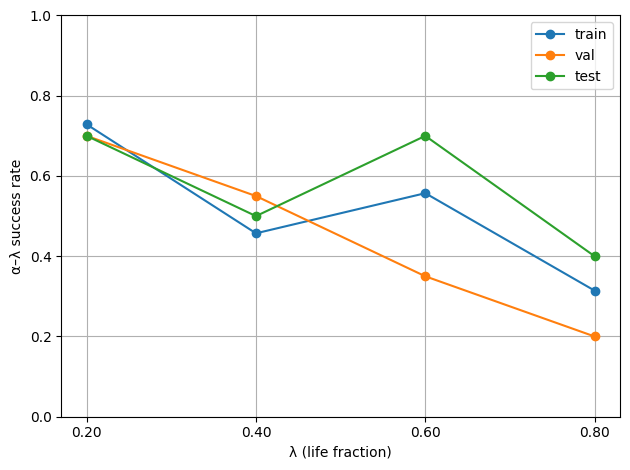

[SAVE] ./alpha_lambda_curve_seed333.png


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SUMMARY_CSV = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\Trial9\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_summary_seed333.csv"
OUT_PNG = r"./alpha_lambda_curve_seed333.png"

LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]
LAM = [float(x) for x in LAM_STRS]
SPLITS_ORDER = ["train", "val", "test"]

df = pd.read_csv(SUMMARY_CSV)

plt.figure()
for split in SPLITS_ORDER:
    sub = df[df["split"] == split]
    if sub.empty:
        continue
    row = sub.iloc[0]
    rates = [float(row.get(f"rate_{ls}", np.nan)) for ls in LAM_STRS]
    plt.plot(LAM, rates, marker="o", label=split)

plt.xticks(LAM, [f"{x:.2f}" for x in LAM])
plt.ylim(0, 1.0)
plt.xlabel("λ (life fraction)")
plt.ylabel("α–λ success rate")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()

print(f"[SAVE] {OUT_PNG}")


In [8]:
import os
from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")
    plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} alpha accuracy zone")
    plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} alpha accuracy zone")

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values
    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")
        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--",
                     label=f"+{alpha:.2f} alpha–lambda accuracy zone")
            plt.plot(x[mask], lower[mask], color="b", linestyle="--",
                     label=f"-{alpha:.2f} alpha–lambda accuracy zone")
        else:
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)

    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            print(f"[WARN] metrics row missing for file={f}. skip.")
            continue
        mrow = mrow.iloc[0].to_dict()

        # evaluation interval
        t_s = int(mrow.get("t_s", sub["cycle"].min()))
        t_e = int(mrow.get("t_e", sub["cycle"].max()))
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            print(f"[WARN] empty df_eval for file={f}. skip.")
            continue

        # t_lambda
        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )

    print(f"DONE. saved figures -> {out_fig_dir}")


if __name__ == "__main__":
    # ✅ 너 환경에 맞게 여기만 수정하면 끝
    cycle_seq_csv = r"./Trial9/seed_333/best_by_val_norm/test_cycle_sequence_mean.csv"
    metrics_csv   = r"./Trial9/seed_333/best_by_val_norm/test_prognostics_metrics_per_file.csv"
    out_fig_dir   = r"./Trial9/seed_333/best_by_val_norm/paper_figures/test_manual"

    make_paper_figures_for_split(
        cycle_seq_csv=cycle_seq_csv,
        metrics_per_file_csv=metrics_csv,
        out_fig_dir=out_fig_dir,
        title_prefix="SEED 333 | BEST | test",
        alpha=0.20,
        lambda_to_plot=0.60,
        max_files=1,   # 1개만 만들기 (원하면 None으로)
        dpi=200,
    )


DONE. saved figures -> ./Trial9/seed_333/best_by_val_norm/paper_figures/test_manual


In [1]:
pip install captum


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 14.6 MB/s  0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/15.8 MB 14.7 MB/s eta 0:00:01
   ------------- -------------------------- 5.5/15.8 MB 15.3 MB/s eta 0:00:01
   --------------------- ------------------ 8.7/15.8 MB 15.3 MB/s eta 0:00:01
   ------------------------------- -------- 12.6/15.8 MB 16.1 MB/s eta 0:00:01
   ---------------------------------- ----- 13.6/15.8 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 13.8 MB/s  0:00:01

  Attempting uninstall: numpy

    Found existing installation: numpy 2.2.5

   ------------- -------------------------- 1/3 [numpy]
   ------------- -------------------------- 1/3 [numpy]
    Uninstalling numpy-2.2.5:
   ------------- -------------------------- 1/3 [numpy]
   ------------- --------------------------

In [ ]:
# ============================================================
# XAI (Integrated Gradients) - Version A (RECOMMENDED)
# Fix: cuDNN RNN backward can only be called in training mode
#   -> switch model.train() temporarily + set LSTM dropout=0.0
# ============================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# !pip install captum
from captum.attr import IntegratedGradients


# ----------------------------
# USER CONFIG (edit here only)
# ----------------------------
DATA_DIR   = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
TRIAL_DIR  = r"./Trial9"
SEED       = 333

CKPT_TAG   = "best_by_val_norm"     # "best_by_val_norm" or "last_epoch"
SPLIT      = "test"                 # "train" / "val" / "test"

SEQ_LEN      = 100
STRIDE       = 5
PRED_HORIZON = 0

HIDDEN_SIZE = 512
NUM_LAYERS  = 2
DROPOUT     = 0.2

BATCH_SIZE  = 256
NUM_SAMPLES = 4000   # 2k~10k 추천
BASELINE    = "zero" # standardized input이면 mean=0과 동일

OUT_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT_TAG, "xai_ig_global_vA", SPLIT)
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("OUT_DIR:", OUT_DIR)


# ----------------------------
# Helpers
# ----------------------------
def load_split_files(seed_dir: str, split: str) -> List[Path]:
    fpath = os.path.join(seed_dir, f"{split}_files.csv")
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing split list: {fpath}")

    names = pd.read_csv(fpath, header=None)[0].astype(str).tolist()
    paths = [Path(DATA_DIR) / n for n in names]

    missing = [p.name for p in paths if not p.exists()]
    if missing:
        raise FileNotFoundError(f"Some split files are missing under DATA_DIR. Examples: {missing[:5]}")
    return paths


def load_scaler_from_csv(seed_dir: str) -> StandardScaler:
    path = os.path.join(seed_dir, "scaler_x_mean_std.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing scaler file: {path}")

    df = pd.read_csv(path)

    scaler = StandardScaler()
    scaler.mean_ = df["mean"].values.astype(np.float64)
    std = df["std"].values.astype(np.float64)
    scaler.var_ = (std ** 2)
    scaler.scale_ = std
    scaler.n_features_in_ = len(df)
    return scaler


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected >=2 cols, got {df.shape[1]}")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch")
    return vce, rul


def compute_dvce(vce: np.ndarray) -> np.ndarray:
    dv = np.zeros_like(vce, dtype=np.float32)
    dv[1:] = vce[1:] - vce[:-1]
    return dv


class WindowedRULDatasetNorm2F(Dataset):
    def __init__(self, file_list: List[Path], seq_len: int, stride: int,
                 pred_horizon: int, scaler_x: StandardScaler):
        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x

        # series: (name, X2(T,2), RUL(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be >0, got {rul0}")

            dv = compute_dvce(vce)
            x2 = np.stack([vce, dv], axis=1).astype(np.float32)  # (T,2)
            self.series.append((fp.name, x2, rul.astype(np.float32), rul0))

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, x2, _rul, _rul0) in enumerate(self.series):
            T = x2.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, x2, rul, rul0 = self.series[fi]

        x = x2[s:s + self.seq_len, :]
        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        x = self.scaler_x.transform(x).astype(np.float32)

        return (
            torch.from_numpy(x),                     # (T,2)
            torch.from_numpy(y_norm),                # (1,)
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


def make_baseline(x: torch.Tensor, mode: str = "zero") -> torch.Tensor:
    # input은 scaler 적용되어 "표준화된 값" → mean baseline = 0 이므로 zero가 가장 흔한 baseline
    if mode == "zero":
        return torch.zeros_like(x)
    return torch.zeros_like(x)


# ----------------------------
# Load artifacts
# ----------------------------
seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")
ckpt_path = os.path.join(seed_dir, f"{CKPT_TAG}.pt")
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Missing checkpoint: {ckpt_path}")

scaler_x = load_scaler_from_csv(seed_dir)
file_list = load_split_files(seed_dir, SPLIT)

ds = WindowedRULDatasetNorm2F(
    file_list=file_list,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    pred_horizon=PRED_HORIZON,
    scaler_x=scaler_x
)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

model = LSTMRegressor(
    input_size=2, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

ig = IntegratedGradients(model)

# ----------------------------
# ✅ FIX for cuDNN RNN backward + stable attribution
# ----------------------------
orig_dropout = float(model.lstm.dropout)
model.train()                 # cuDNN RNN backward 허용
model.lstm.dropout = 0.0      # attribution 안정화 (dropout OFF)

# ----------------------------
# Compute global attributions
# ----------------------------
feat_abs_sum = np.zeros((2,), dtype=np.float64)
time_abs_sum = np.zeros((SEQ_LEN,), dtype=np.float64)
tf_abs_sum   = np.zeros((SEQ_LEN, 2), dtype=np.float64)

n_total = 0
for batch in loader:
    x, y_norm, name, s, y_cycles, rul0 = batch
    x = x.to(device)

    if n_total >= NUM_SAMPLES:
        break

    baseline = make_baseline(x, BASELINE).to(device)

    # IG attribution: (B,T,2)
    attr = ig.attribute(x, baselines=baseline)
    attr = attr.detach().cpu().numpy()

    abs_attr = np.abs(attr)
    feat_abs_sum += abs_attr.sum(axis=(0, 1))
    time_abs_sum += abs_attr.sum(axis=(0, 2))
    tf_abs_sum   += abs_attr.sum(axis=0)

    n_total += x.shape[0]

print("used windows:", n_total)

# ----------------------------
# Restore model state
# ----------------------------
model.lstm.dropout = orig_dropout
model.eval()

# ----------------------------
# Normalize + Save
# ----------------------------
feat_imp = feat_abs_sum / (feat_abs_sum.sum() + 1e-12)
time_imp = time_abs_sum / (time_abs_sum.sum() + 1e-12)
tf_imp   = tf_abs_sum   / (tf_abs_sum.sum()   + 1e-12)

pd.DataFrame({"feature": ["min_vce", "d_min_vce"], "importance": feat_imp}).to_csv(
    os.path.join(OUT_DIR, "global_feature_importance.csv"), index=False
)
pd.DataFrame({"t_in_window": np.arange(SEQ_LEN), "importance": time_imp}).to_csv(
    os.path.join(OUT_DIR, "global_time_importance.csv"), index=False
)

rows = []
for t in range(SEQ_LEN):
    rows.append({"t_in_window": t, "feature": "min_vce",   "importance": tf_imp[t, 0]})
    rows.append({"t_in_window": t, "feature": "d_min_vce", "importance": tf_imp[t, 1]})
pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "global_time_feature_importance.csv"), index=False)

# plots
plt.figure()
plt.bar(["min_vce", "d_min_vce"], feat_imp)
plt.ylabel("Normalized |IG attribution|")
plt.title(f"Global Feature Importance (IG) | seed={SEED} | {CKPT_TAG} | {SPLIT}")
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "global_feature_importance.png"), dpi=200, bbox_inches="tight")
plt.close()

plt.figure()
plt.plot(np.arange(SEQ_LEN), time_imp)
plt.xlabel("t in window")
plt.ylabel("Normalized |IG attribution|")
plt.title(f"Global Time Importance (IG) | seed={SEED} | {CKPT_TAG} | {SPLIT}")
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "global_time_importance.png"), dpi=200, bbox_inches="tight")
plt.close()

print("[DONE] Saved XAI results to:", OUT_DIR)

# global feature importance.cvs: 모델이 주로 보는 물리량은 무엇인가?
# global time imporatnce.csv: window 안에서 어느 시점을 가장 본다?
# global time feature imporatnce.csv: 언제, 어떤 feature가 중요한가? 


device: cuda
OUT_DIR: ./Trial9\seed_333\best_by_val_norm\xai_ig_global_vA\test


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_45064\3727629794.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

used windows: 4096
[DONE] Saved XAI results to: ./Trial9\seed_333\best_by_val_norm\xai_ig_global_vA\test


In [ ]:
# ============================================================
# XAI DEBUG PACK (Trial9)
# 1) Error-conditioned Local XAI
# 2) PH-conditioned Group XAI
# 3) λ-conditioned Local XAI (λ=0.6)
#
# Outputs (under Trial9/seed_<seed>/<ckpt>/xai_debug_pack/<split>/):
#  - 01_error_group_feature_time_importance.(csv/png)
#  - 02_ph_good_vs_bad_feature_importance.(csv/png)  (+ time plots)
#  - 03_lambda_local_feature_time_importance.(csv/png)
#
# Requirements:
#   pip install captum
# ============================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
from typing import List, Tuple, Dict, Optional
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients


# ----------------------------
# USER CONFIG
# ----------------------------
DATA_DIR   = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
TRIAL_DIR  = r"./Trial9"
SEED       = 333
CKPT_TAG   = "best_by_val_norm"   # "best_by_val_norm" or "last_epoch"
SPLIT      = "test"               # "train"/"val"/"test"

SEQ_LEN      = 100
STRIDE       = 5
PRED_HORIZON = 0

HIDDEN_SIZE = 512
NUM_LAYERS  = 2
DROPOUT     = 0.2

BATCH_SIZE_IG = 128               # IG는 메모리/시간 고려해서 더 작게 추천
BASELINE = "zero"

# 샘플 수 (각 분석마다 몇 개 window 쓸지)
N_ERROR_SAMPLES  = 1000
N_GROUP_SAMPLES  = 2000
N_LAMBDA_SAMPLES = 1000

# Error-conditioned 기준: absolute error threshold (cycles)
# - 고정값으로 주면 쉬움. 또는 quantile 방식 사용 가능.
ERROR_MODE = "quantile"   # "quantile" or "fixed"
ERROR_Q = 0.90            # 상위 10% 오차를 "error windows"로
ERROR_FIXED = 300.0       # (ERROR_MODE="fixed"일 때)

# PH group split 기준
PH_GOOD_MAX_CONV_CYCLES = 200     # convergence_cycles <= 이 값이면 "PH good"
# (없으면 자동으로 median split으로 fallback)

# λ-conditioned 설정
LAMBDA_TARGET = 0.60
LAMBDA_WINDOW_BAND = 50           # t_lambda ± band 안쪽 windows만 사용

OUT_DIR = os.path.join(
    TRIAL_DIR, f"seed_{SEED}", CKPT_TAG, "xai_debug_pack", SPLIT
)
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("OUT_DIR:", OUT_DIR)


# ============================================================
# Helpers: load artifacts
# ============================================================
def load_scaler_from_csv(seed_dir: str) -> StandardScaler:
    path = os.path.join(seed_dir, "scaler_x_mean_std.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing scaler file: {path}")
    df = pd.read_csv(path)
    scaler = StandardScaler()
    scaler.mean_ = df["mean"].values.astype(np.float64)
    std = df["std"].values.astype(np.float64)
    scaler.var_ = (std ** 2)
    scaler.scale_ = std
    scaler.n_features_in_ = len(df)
    return scaler


# ============================================================
# Dataset (same behavior as training) + also return cycle index
# ============================================================
def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected >=2 cols")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch")
    return vce, rul


def compute_dvce(vce: np.ndarray) -> np.ndarray:
    dv = np.zeros_like(vce, dtype=np.float32)
    dv[1:] = vce[1:] - vce[:-1]
    return dv


class WindowedRULDatasetNorm2F_WithCycle(Dataset):
    """
    returns:
      x(T,2), y_norm(1), file, start_idx, cycle_target, y_cycles, rul0
    """
    def __init__(self, file_list: List[Path], seq_len: int, stride: int,
                 pred_horizon: int, scaler_x: StandardScaler):
        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x

        self.series: List[Tuple[str, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be >0")
            dv = compute_dvce(vce)
            x2 = np.stack([vce, dv], axis=1).astype(np.float32)
            self.series.append((fp.name, x2, rul.astype(np.float32), rul0))

        self.index: List[Tuple[int, int]] = []
        for fi, (_name, x2, _rul, _rul0) in enumerate(self.series):
            T = x2.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, x2, rul, rul0 = self.series[fi]
        x = x2[s:s + self.seq_len, :]
        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)
        x = self.scaler_x.transform(x).astype(np.float32)
        cycle_target = int(s + (self.seq_len - 1) + self.pred_horizon)
        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(cycle_target, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# Model
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


def make_baseline(x: torch.Tensor, mode: str = "zero") -> torch.Tensor:
    return torch.zeros_like(x)


# ============================================================
# Load saved CSVs produced by your Trial9 export (recommended)
# - windows predictions: <seed>/<ckpt>/test_predictions_windows.csv
# - metrics per file:    <seed>/<ckpt>/test_prognostics_metrics_per_file.csv
# ============================================================
seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")
ckpt_path = os.path.join(seed_dir, f"{CKPT_TAG}.pt")
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Missing checkpoint: {ckpt_path}")

sub_dir = os.path.join(seed_dir, CKPT_TAG)
win_csv = os.path.join(sub_dir, f"{SPLIT}_predictions_windows.csv")
met_csv = os.path.join(sub_dir, f"{SPLIT}_prognostics_metrics_per_file.csv")

if not os.path.exists(win_csv):
    raise FileNotFoundError(f"Missing windows prediction CSV: {win_csv}")
if not os.path.exists(met_csv):
    raise FileNotFoundError(f"Missing metrics-per-file CSV: {met_csv}")

dfw = pd.read_csv(win_csv)
dfm = pd.read_csv(met_csv)

# absolute error per window (cycles)
dfw["abs_err"] = np.abs(dfw["RUL_pred"].values - dfw["RUL_true"].values)

print("Loaded:")
print(" - windows:", win_csv, "rows:", len(dfw))
print(" - metrics:", met_csv, "rows:", len(dfm))

# ============================================================
# Build dataset/loader (for sampling windows & getting x)
# We must use the EXACT scaler from training.
# ============================================================
scaler_x = load_scaler_from_csv(seed_dir)

# file list for this split = from saved split list
split_list_path = os.path.join(seed_dir, f"{SPLIT}_files.csv")
names = pd.read_csv(split_list_path, header=None)[0].astype(str).tolist()
file_list = [Path(DATA_DIR) / n for n in names]

ds = WindowedRULDatasetNorm2F_WithCycle(
    file_list=file_list,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    pred_horizon=PRED_HORIZON,
    scaler_x=scaler_x
)

# We'll NOT rely on DataLoader shuffle for targeted sampling.
# We'll sample indices from ds by matching (file, start_idx).
# Build fast lookup: (file, start_idx) -> ds_index
lookup: Dict[Tuple[str, int], int] = {}
for idx in range(len(ds)):
    _x, _y, name, s, cyc, yc, r0 = ds[idx]
    lookup[(name, int(s.item()))] = idx

print("Dataset windows:", len(ds), "Lookup size:", len(lookup))


# ============================================================
# Load model + Captum IG (Version A fix)
# ============================================================
model = LSTMRegressor(2, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

ig = IntegratedGradients(model)

# ✅ cuDNN RNN backward fix + stable attribution
orig_dropout = float(model.lstm.dropout)
model.train()
model.lstm.dropout = 0.0


# ============================================================
# Core: compute IG over a selected set of windows
# windows_df must have columns: file, start_idx
# ============================================================
def compute_ig_for_windows(windows_df: pd.DataFrame, max_samples: int) -> Dict[str, np.ndarray]:
    windows_df = windows_df.copy()

    # keep only rows that exist in lookup
    ok_mask = []
    for _, r in windows_df.iterrows():
        ok_mask.append((r["file"], int(r["start_idx"])) in lookup)
    windows_df = windows_df[np.array(ok_mask, dtype=bool)]

    if windows_df.empty:
        raise ValueError("No matching windows found in dataset for IG.")

    # sample
    if len(windows_df) > max_samples:
        windows_df = windows_df.sample(n=max_samples, random_state=0)

    # batch through
    feat_abs_sum = np.zeros((2,), dtype=np.float64)
    time_abs_sum = np.zeros((SEQ_LEN,), dtype=np.float64)
    tf_abs_sum   = np.zeros((SEQ_LEN, 2), dtype=np.float64)

    n = 0
    batch_x = []
    for _, r in windows_df.iterrows():
        ds_idx = lookup[(r["file"], int(r["start_idx"]))]
        x, *_ = ds[ds_idx]
        batch_x.append(x.numpy())
        n += 1

        if len(batch_x) == BATCH_SIZE_IG:
            xb = torch.tensor(np.stack(batch_x, axis=0), dtype=torch.float32).to(device)
            baseline = make_baseline(xb, BASELINE).to(device)

            attr = ig.attribute(xb, baselines=baseline).detach().cpu().numpy()
            abs_attr = np.abs(attr)

            feat_abs_sum += abs_attr.sum(axis=(0, 1))
            time_abs_sum += abs_attr.sum(axis=(0, 2))
            tf_abs_sum   += abs_attr.sum(axis=0)

            batch_x = []

    # remaining
    if len(batch_x) > 0:
        xb = torch.tensor(np.stack(batch_x, axis=0), dtype=torch.float32).to(device)
        baseline = make_baseline(xb, BASELINE).to(device)
        attr = ig.attribute(xb, baselines=baseline).detach().cpu().numpy()
        abs_attr = np.abs(attr)

        feat_abs_sum += abs_attr.sum(axis=(0, 1))
        time_abs_sum += abs_attr.sum(axis=(0, 2))
        tf_abs_sum   += abs_attr.sum(axis=0)

    # normalize
    feat_imp = feat_abs_sum / (feat_abs_sum.sum() + 1e-12)
    time_imp = time_abs_sum / (time_abs_sum.sum() + 1e-12)
    tf_imp   = tf_abs_sum   / (tf_abs_sum.sum()   + 1e-12)

    return {
        "feat_imp": feat_imp,
        "time_imp": time_imp,
        "tf_imp": tf_imp,
        "n_used": np.array([min(len(windows_df), max_samples)], dtype=np.int64),
        "windows_df": windows_df,
    }


def save_importance(prefix: str, feat_imp: np.ndarray, time_imp: np.ndarray) -> None:
    # CSVs
    pd.DataFrame({"feature": ["min_vce", "d_min_vce"], "importance": feat_imp}).to_csv(
        os.path.join(OUT_DIR, f"{prefix}_feature_importance.csv"), index=False
    )
    pd.DataFrame({"t_in_window": np.arange(SEQ_LEN), "importance": time_imp}).to_csv(
        os.path.join(OUT_DIR, f"{prefix}_time_importance.csv"), index=False
    )

    # PNGs
    plt.figure()
    plt.bar(["min_vce", "d_min_vce"], feat_imp)
    plt.ylabel("Normalized |IG attribution|")
    plt.title(prefix)
    plt.grid(True)
    plt.savefig(os.path.join(OUT_DIR, f"{prefix}_feature_importance.png"), dpi=200, bbox_inches="tight")
    plt.close()

    plt.figure()
    plt.plot(np.arange(SEQ_LEN), time_imp)
    plt.xlabel("t in window")
    plt.ylabel("Normalized |IG attribution|")
    plt.title(prefix)
    plt.grid(True)
    plt.savefig(os.path.join(OUT_DIR, f"{prefix}_time_importance.png"), dpi=200, bbox_inches="tight")
    plt.close()


# ============================================================
# (1) Error-conditioned Local XAI
# ============================================================
if ERROR_MODE == "quantile":
    thr = float(dfw["abs_err"].quantile(ERROR_Q))
else:
    thr = float(ERROR_FIXED)

df_error = dfw[dfw["abs_err"] >= thr].copy()
print(f"\n[1] Error-conditioned: mode={ERROR_MODE}, threshold={thr:.3f}, n={len(df_error)}")

res_err = compute_ig_for_windows(df_error[["file", "start_idx"]], max_samples=N_ERROR_SAMPLES)
save_importance(
    prefix="01_error_group_feature_time_importance",
    feat_imp=res_err["feat_imp"],
    time_imp=res_err["time_imp"],
)
res_err["windows_df"].to_csv(os.path.join(OUT_DIR, "01_error_windows_used.csv"), index=False)


# ============================================================
# (2) PH-conditioned Group XAI (PH good vs bad)
#   - uses Convergence_cycles or t_PH_start availability
# ============================================================
# clean numeric
dfm2 = dfm.copy()
for col in ["Convergence_cycles", "t_PH_start"]:
    if col in dfm2.columns:
        dfm2[col] = pd.to_numeric(dfm2[col], errors="coerce")

# Define groups
if "Convergence_cycles" in dfm2.columns and dfm2["Convergence_cycles"].notna().any():
    conv = dfm2["Convergence_cycles"].dropna()
    if np.isfinite(PH_GOOD_MAX_CONV_CYCLES):
        good_files = dfm2.loc[dfm2["Convergence_cycles"] <= PH_GOOD_MAX_CONV_CYCLES, "file"].astype(str).tolist()
        bad_files  = dfm2.loc[dfm2["Convergence_cycles"] >  PH_GOOD_MAX_CONV_CYCLES, "file"].astype(str).tolist()

        # fallback if too unbalanced
        if len(good_files) < 3 or len(bad_files) < 3:
            med = float(np.median(conv.values))
            good_files = dfm2.loc[dfm2["Convergence_cycles"] <= med, "file"].astype(str).tolist()
            bad_files  = dfm2.loc[dfm2["Convergence_cycles"] >  med, "file"].astype(str).tolist()
    else:
        med = float(np.median(conv.values))
        good_files = dfm2.loc[dfm2["Convergence_cycles"] <= med, "file"].astype(str).tolist()
        bad_files  = dfm2.loc[dfm2["Convergence_cycles"] >  med, "file"].astype(str).tolist()
elif "t_PH_start" in dfm2.columns:
    good_files = dfm2.loc[dfm2["t_PH_start"].notna(), "file"].astype(str).tolist()
    bad_files  = dfm2.loc[dfm2["t_PH_start"].isna(), "file"].astype(str).tolist()
else:
    raise ValueError("Metrics CSV does not include Convergence_cycles or t_PH_start. Cannot form PH groups.")

print(f"\n[2] PH-conditioned: good_files={len(good_files)} bad_files={len(bad_files)}")

df_good = dfw[dfw["file"].isin(good_files)].copy()
df_bad  = dfw[dfw["file"].isin(bad_files)].copy()

# if empty fallback
if df_good.empty or df_bad.empty:
    raise ValueError("PH grouping produced empty windows. Check metrics CSV and file names.")

res_good = compute_ig_for_windows(df_good[["file", "start_idx"]], max_samples=N_GROUP_SAMPLES)
res_bad  = compute_ig_for_windows(df_bad[["file", "start_idx"]],  max_samples=N_GROUP_SAMPLES)

save_importance("02_ph_good_feature_time_importance", res_good["feat_imp"], res_good["time_imp"])
save_importance("02_ph_bad_feature_time_importance",  res_bad["feat_imp"],  res_bad["time_imp"])

pd.DataFrame({"good_files": good_files}).to_csv(os.path.join(OUT_DIR, "02_ph_good_files.csv"), index=False)
pd.DataFrame({"bad_files": bad_files}).to_csv(os.path.join(OUT_DIR, "02_ph_bad_files.csv"), index=False)
res_good["windows_df"].to_csv(os.path.join(OUT_DIR, "02_ph_good_windows_used.csv"), index=False)
res_bad["windows_df"].to_csv(os.path.join(OUT_DIR, "02_ph_bad_windows_used.csv"), index=False)


# ============================================================
# (3) λ-conditioned Local XAI (λ=0.60)
#   - use cycle sequence mean CSV to get t_lambda for each file
# ============================================================
seq_csv = os.path.join(sub_dir, f"{SPLIT}_cycle_sequence_mean.csv")
if not os.path.exists(seq_csv):
    raise FileNotFoundError(f"Missing cycle sequence mean CSV: {seq_csv}")

dfseq = pd.read_csv(seq_csv)
dfseq = dfseq.sort_values(["file", "cycle"]).reset_index(drop=True)

# compute t_lambda per file using true RUL and rul0
tlam_map: Dict[str, int] = {}
for f in dfseq["file"].unique():
    sub = dfseq[dfseq["file"] == f]
    rul0 = float(sub["rul0"].iloc[0])
    target = (1.0 - float(LAMBDA_TARGET)) * rul0
    idx = int(np.argmin(np.abs(sub["RUL_true"].values - target)))
    t_lam = int(sub.iloc[idx]["cycle"])
    tlam_map[str(f)] = t_lam

dfw["t_lambda"] = dfw["file"].map(tlam_map).astype("float64")
dfw["dist_to_tlam"] = np.abs(dfw["cycle"].values - dfw["t_lambda"].values)

df_lam = dfw[dfw["dist_to_tlam"] <= float(LAMBDA_WINDOW_BAND)].copy()
print(f"\n[3] Lambda-conditioned: λ={LAMBDA_TARGET:.2f}, band=±{LAMBDA_WINDOW_BAND}, n={len(df_lam)}")

res_lam = compute_ig_for_windows(df_lam[["file", "start_idx"]], max_samples=N_LAMBDA_SAMPLES)
save_importance(
    prefix=f"03_lambda_{LAMBDA_TARGET:.2f}_feature_time_importance",
    feat_imp=res_lam["feat_imp"],
    time_imp=res_lam["time_imp"],
)
res_lam["windows_df"].to_csv(os.path.join(OUT_DIR, "03_lambda_windows_used.csv"), index=False)


# ============================================================
# Restore model state
# ============================================================
model.lstm.dropout = orig_dropout
model.eval()

print("\n[DONE] XAI Debug Pack saved to:", OUT_DIR)

# 01 errir group *: feature importance (오차가 큰 window들에서 모델이 무엇에 의존하는지), time importance: 오차가 큰 window들에서 window 내 어떤 시점이 중요한지
# 02 ph good vs bad *: feature importance + time importance (PH good/bad 그룹별 모델이 무엇에 의존하는지, window 내 어떤 시점이 중요한지)
# 03 lambda 0.6 *: 0.6 구간에서 feature imporatnce, time imporatance, lambda_windows_used

device: cuda
OUT_DIR: ./Trial9\seed_333\best_by_val_norm\xai_debug_pack\test
Loaded:
 - windows: ./Trial9\seed_333\best_by_val_norm\test_predictions_windows.csv rows: 8621
 - metrics: ./Trial9\seed_333\best_by_val_norm\test_prognostics_metrics_per_file.csv rows: 10
Dataset windows: 8621 Lookup size: 8621

[1] Error-conditioned: mode=quantile, threshold=3399.648, n=863


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_45064\2139996575.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca


[2] PH-conditioned: good_files=6 bad_files=3

[3] Lambda-conditioned: λ=0.60, band=±50, n=210

[DONE] XAI Debug Pack saved to: ./Trial9\seed_333\best_by_val_norm\xai_debug_pack\test
